In [1]:
import os
from IPython import get_ipython

In [2]:
from pathlib import Path
from petbox import dca
from data import rate as data_q, time as data_t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

img_path = Path('../docs/img')

get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'")

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (2.5*5, 2.5*5)
plt.rcParams['font.size'] = 16

#### Setup time series for Forecasts and calculate cumlative production of data

In [3]:
# We have this function handy, but want a bit more precision for these examples
t = dca.get_time(n=1001)

# Calculate cumulative volume array of data
data_N = np.cumsum(data_q * np.diff(data_t, prepend=data_t[0]))

# Calculate diagnostic functions D, beta, and b
data_D = -dca.bourdet(data_q, data_t, L=0.35, xlog=False, ylog=True)
data_beta = data_D * data_t
data_b = dca.bourdet(1 / data_D, data_t, L=0.25, xlog=False, ylog=False)

## Primary Phase Decline Curve Models

### Modified Hyperbolic Model  
>Robertson, S. 1988. Generalized Hyperbolic Equation. Available from SPE, Richardson, Texas, USA. SPE-18731-MS.

In [4]:
mh = dca.MH(qi=725, Di=0.85, bi=0.6, Dterm=0.2)
q_mh = mh.rate(t)
N_mh = mh.cum(t)
D_mh = mh.D(t)
b_mh = mh.b(t)
beta_mh = mh.beta(t)
N_mh *= data_N[-1] / mh.cum(data_t[-1])

### Transient Hyperbolic Model
>Fulford, D. S., and Blasingame, T. A. 2013. Evaluation of Time-Rate Performance of Shale Wells using the Transient Hyperbolic Relation. Presented at SPE Unconventional Resources Conference – Canada in Calgary, Alberta, Canda, 5–7 November. SPE-167242-MS. https://doi.org/10.2118/167242-MS.

In [5]:
thm = dca.THM(qi=750, Di=.8, bi=2, bf=.5, telf=28)
q_trans = thm.transient_rate(t)
N_trans = thm.transient_cum(t)
D_trans = thm.transient_D(t)
b_trans = thm.transient_b(t)
beta_trans = thm.transient_beta(t)
N_trans *= data_N[-1] / thm.transient_cum(data_t[-1])

### Transient Hyperbolic Model Analytic Approximation
>Fulford, D.S. 2018. A Model-Based Diagnostic Workflow for Time-Rate Performance of Unconventional Wells. Presented at Unconventional Resources Conference in Houston, Texas, USA, 23–25 July. URTeC-2903036. https://doi.org/10.15530/urtec-2018-2903036.

In [6]:
q_thm = thm.rate(t)
N_thm = thm.cum(t)
D_thm = thm.D(t)
b_thm = thm.b(t)
beta_thm = thm.beta(t)
N_thm *= data_N[-1] / thm.cum(data_t[-1])

##### Timing Comparison
If performance is a consideration, the approximation is much faster.

In [7]:
%timeit thm.transient_rate(t)

64.9 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit thm.rate(t)

86.9 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Power-Law Exponential Model
>Ilk, D., Perego, A. D., Rushing, J. A., and Blasingame, T. A. 2008. Exponential vs. Hyperbolic Decline in Tight Gas Sands – Understanding the Origin and Implications for Reserve Estimates Using Arps Decline Curves. Presented at SPE Annual Technical Conference and Exhibition in Denver, Colorado, USA, 21–24 September. SPE-116731-MS. https://doi.org/10.2118/116731-MS.

>Ilk, D., Rushing, J. A., and Blasingame, T. A. 2009. Decline Curve Analysis for HP/HT Gas Wells: Theory and Applications. Presented at SPE Annual Technical Conference and Exhibition in New Orleands, Louisiana, USA, 4–7 October. SPE-125031-MS. https://doi.org/10.2118/125031-MS.

In [7]:
ple = dca.PLE(qi=750, Di=.1, Dinf=.00001, n=.5)
q_ple = ple.rate(t)
N_ple = ple.cum(t)
D_ple = ple.D(t)
b_ple = ple.b(t)
beta_ple = ple.beta(t)
N_ple *= data_N[-1] /  ple.cum(data_t[-1])

### Stretched Exponential
>Valkó, P. P. Assigning Value to Stimulation in the Barnett Shale: A Simultaneous Analysis of 7000 Plus Production Histories and Well Completion Records. 2009. Presented at SPE Hydraulic Fracturing Technology Conference in College Station, Texas, USA, 19–21 January. SPE-119369-MS. https://doi.org/10.2118/119369-MS.

In [8]:
se = dca.SE(qi=715, tau=90.0, n=.5)
q_se = se.rate(t)
N_se = se.cum(t)
D_se = se.D(t)
b_se = se.b(t)
beta_se = se.beta(t)
N_se *= data_N[-1] / se.cum(data_t[-1])

### Duong Model
>Duong, A. N. 2001. Rate-Decline Analysis for Fracture-Dominated Shale Reservoirs. SPE Res Eval & Eng 14 (3): 377–387. SPE-137748-PA. https://doi.org/10.2118/137748-PA.

In [9]:
dg = dca.Duong(qi=715, a=2.8, m=1.4)
q_dg = dg.rate(t)
N_dg = dg.cum(t)
D_dg = dg.D(t)
b_dg = dg.b(t)
beta_dg = dg.beta(t)
N_dg *= data_N[-1] / dg.cum(data_t[-1])

## Primary Phase Diagnostic Plots

### Time-Rate Model Diagnostic Plots

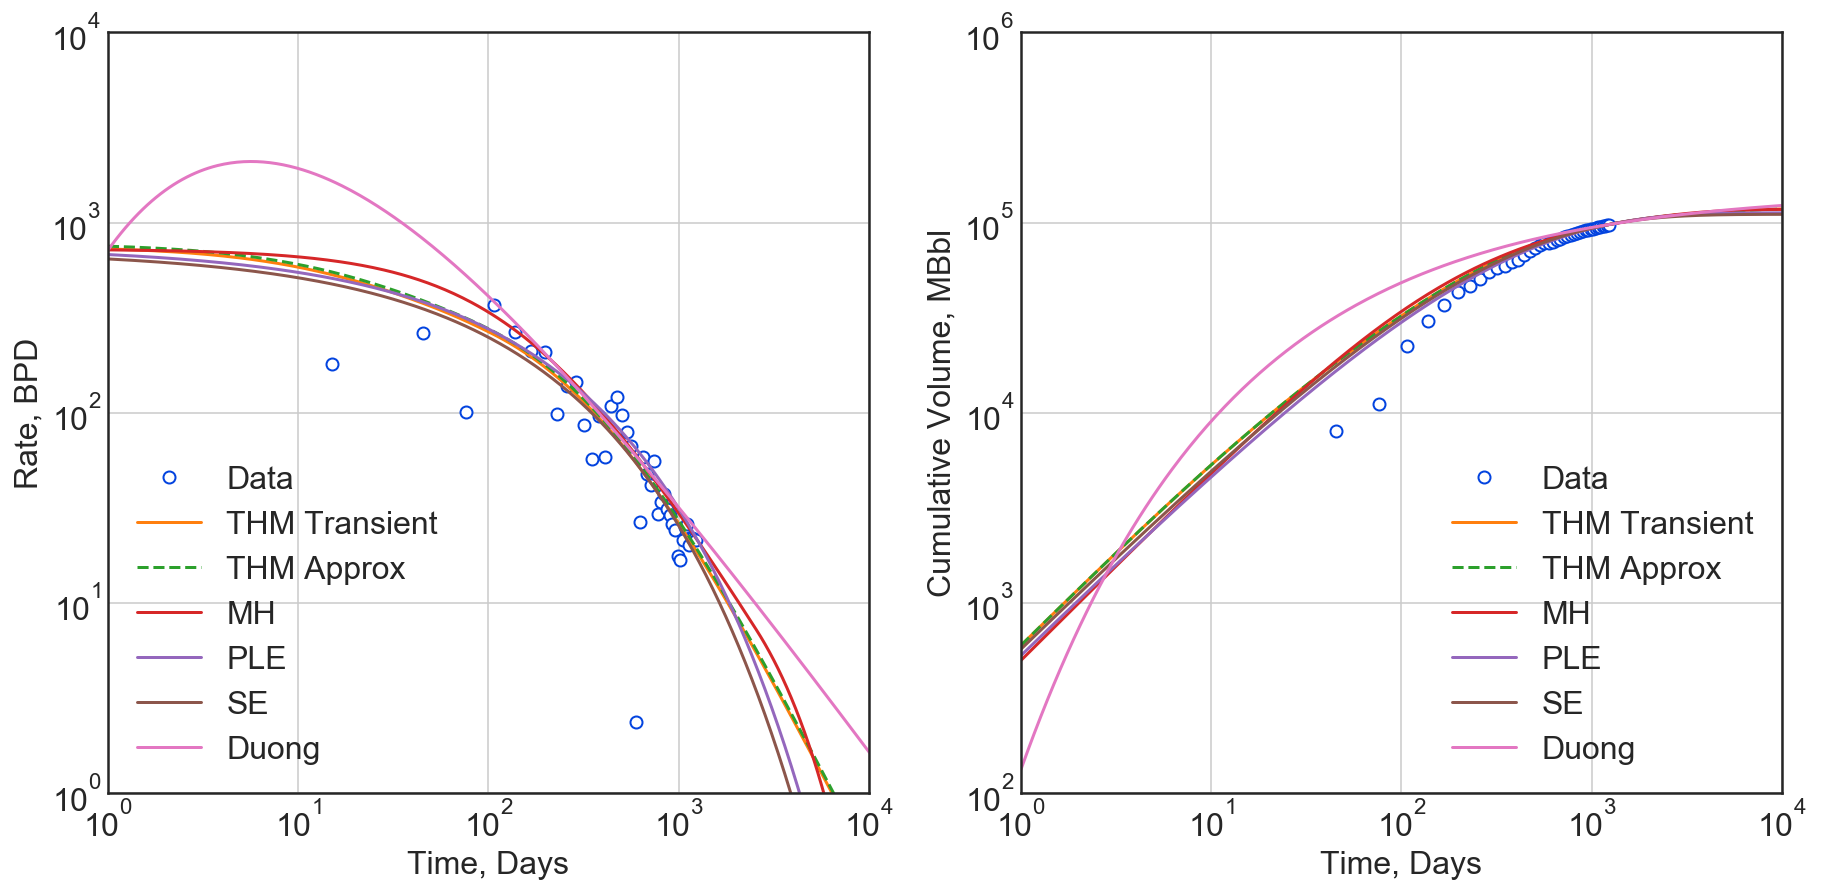

In [10]:
# Rate vs Time
fig = plt.figure(figsize=(15, 7.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data_t, data_q, 'o', mfc='w', label='Data')
ax1.plot(t, q_thm, label='THM Transient')
ax1.plot(t, q_trans, ls='--', label='THM Approx')
ax1.plot(t, q_mh, label='MH')
ax1.plot(t, q_ple, label='PLE')
ax1.plot(t, q_se, label='SE')
ax1.plot(t, q_dg, label='Duong')

ax1.set(xscale='log', yscale='log', ylabel='Rate, BPD', xlabel='Time, Days')
ax1.set(ylim=(1e0, 1e4), xlim=(1e0, 1e4))
ax1.set_aspect(1)
ax1.grid()
ax1.legend()

# Cumulative Volume vs Time
ax2.plot(data_t, data_N, 'o', mfc='w', label='Data')
ax2.plot(t, N_trans, label='THM Transient')
ax2.plot(t, N_thm, ls='--', label='THM Approx')
ax2.plot(t, N_mh, label='MH')
ax2.plot(t, N_ple, label='PLE')
ax2.plot(t, N_se, label='SE')
ax2.plot(t, N_dg, label='Duong')

ax2.set(xscale='log', yscale='log', ylim=(1e2, 1e6), xlim=(1e0, 1e4))
ax2.set(ylabel='Cumulative Volume, MBbl', xlabel='Time, Days')
ax2.set_aspect(1)
ax2.grid()
ax2.legend()

plt.savefig(img_path / 'model.png')

### Diagnostic Function Plots

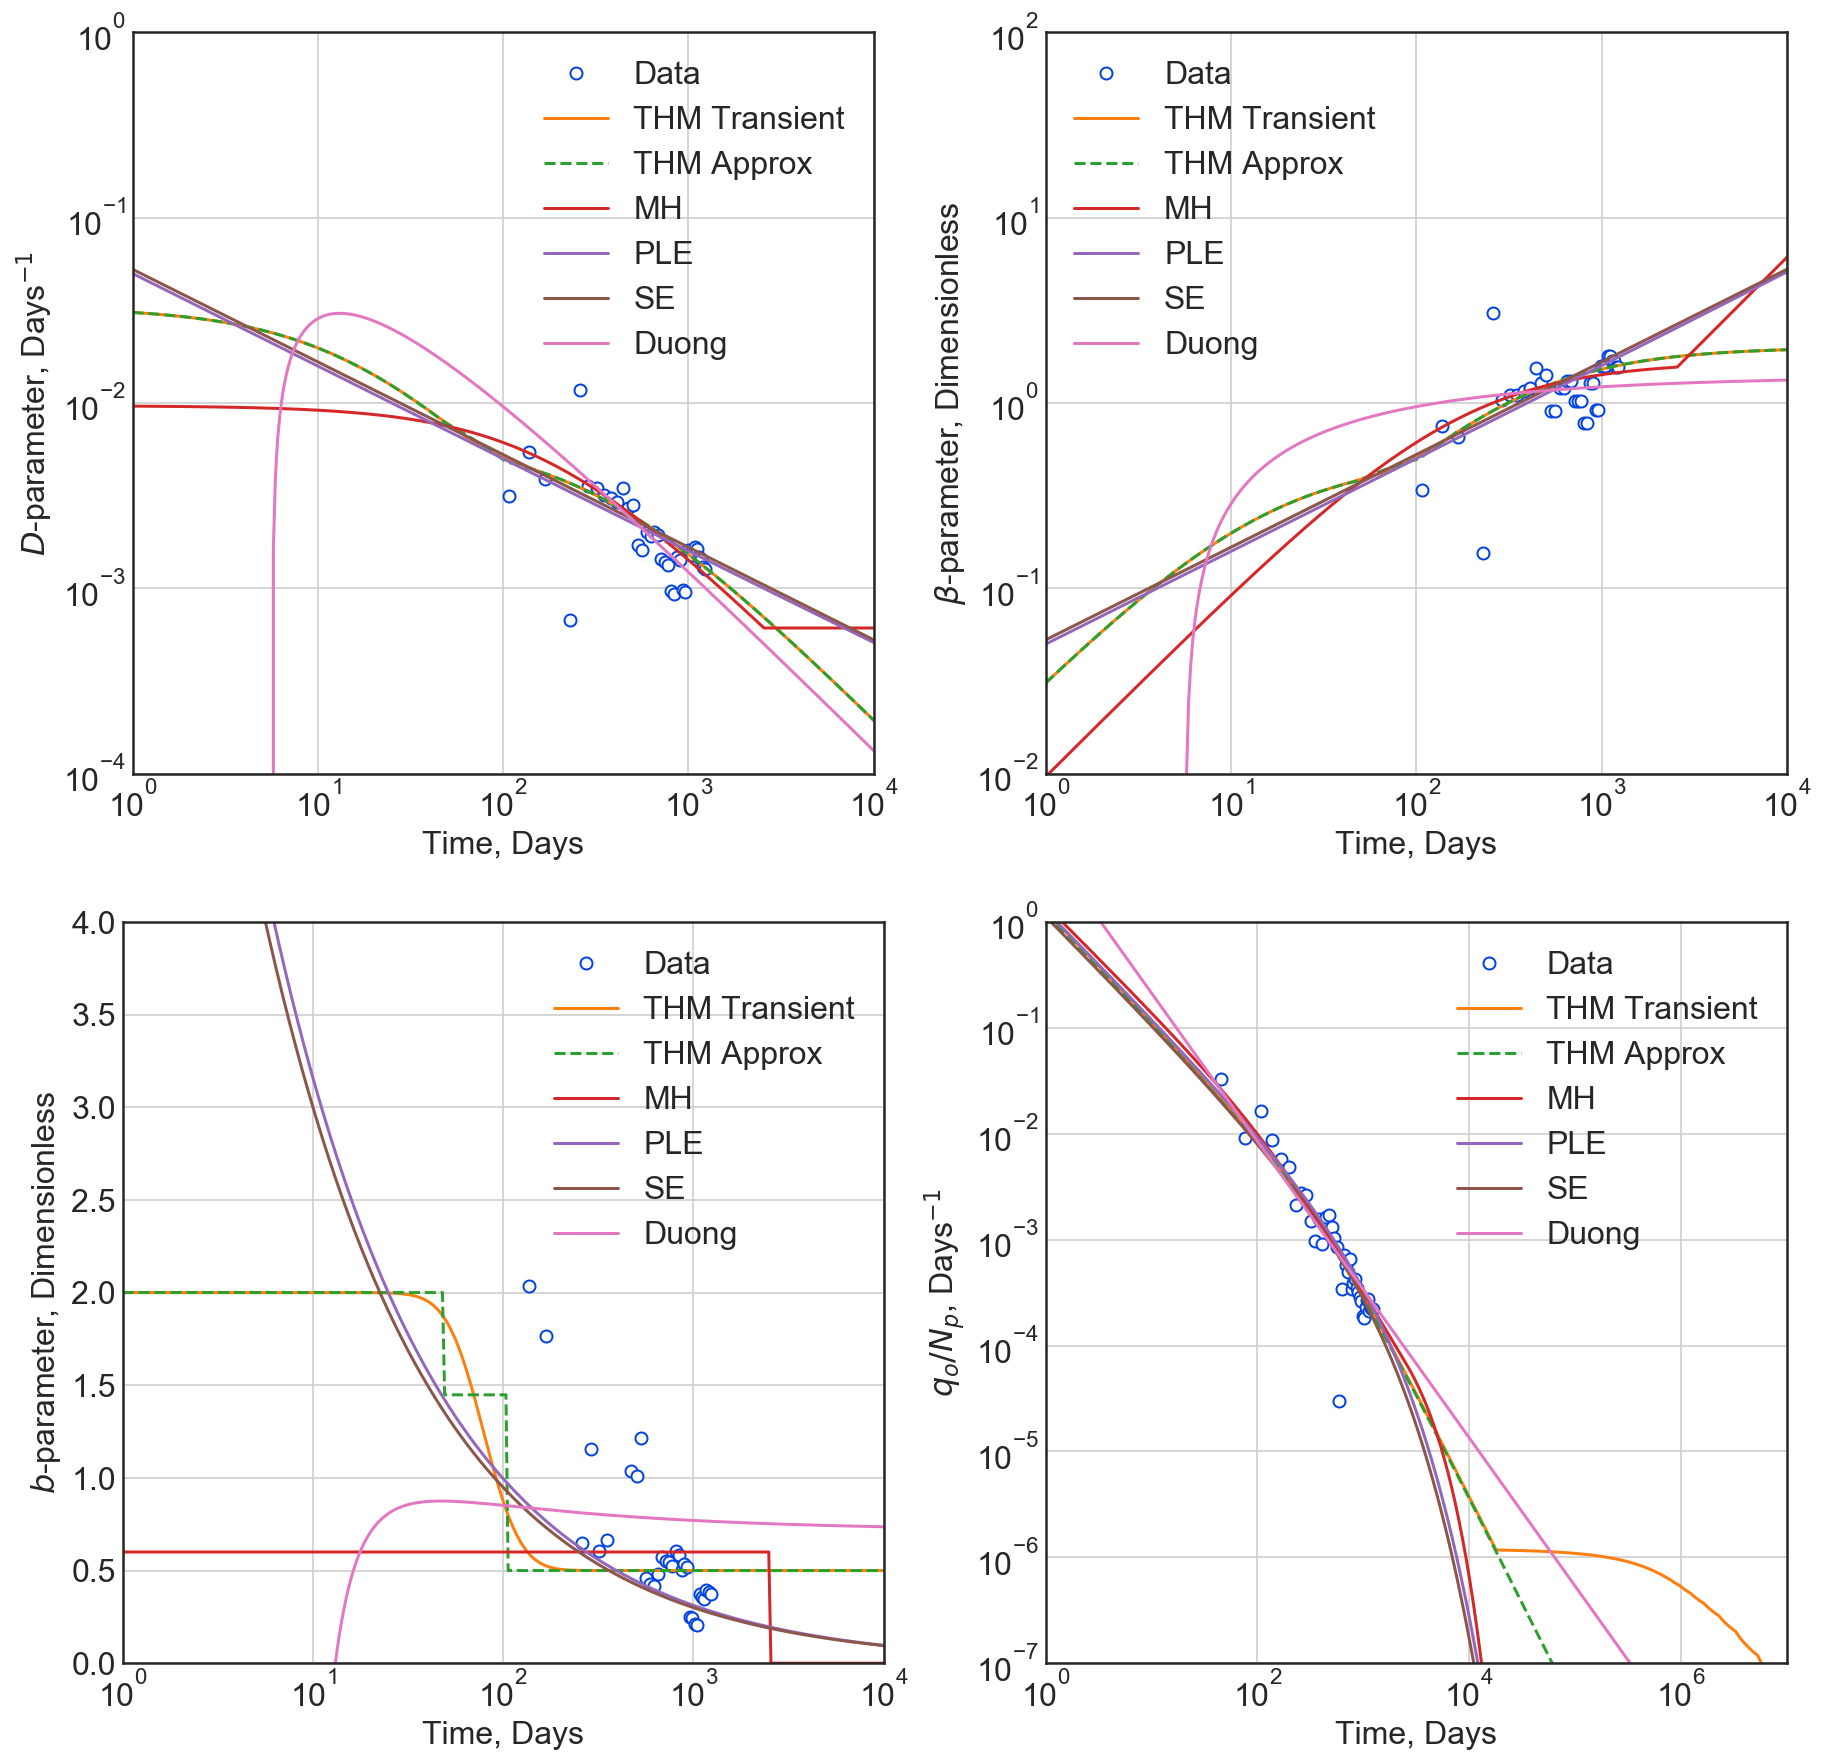

In [11]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# D-parameter vs Time
ax1.plot(data_t, data_D, 'o', mfc='w', label='Data')
# ax1.plot(data_t, data_D2, 'o', label='Data2')
ax1.plot(t, D_trans, label='THM Transient')
ax1.plot(t, D_thm, ls='--', label='THM Approx')
ax1.plot(t, D_mh, label='MH')
ax1.plot(t, D_ple, label='PLE')
ax1.plot(t, D_se, label='SE')
ax1.plot(t, D_dg, label='Duong')
ax1.set(xscale='log', yscale='log', ylim=(1e-4, 1e0))
ax1.set(ylabel='$D$-parameter, Days$^{-1}$', xlabel='Time, Days')

# beta-parameter vs Time
ax2.plot(data_t, data_D * data_t, 'o', mfc='w', label='Data')
ax2.plot(t, beta_trans, label='THM Transient')
ax2.plot(t, beta_thm, ls='--', label='THM Approx')
ax2.plot(t, beta_mh, label='MH')
ax2.plot(t, beta_ple, label='PLE')
ax2.plot(t, beta_se, label='SE')
ax2.plot(t, beta_dg, label='Duong')
ax2.set(xscale='log', yscale='log', ylim=(1e-2, 1e2))
ax2.set(ylabel=r'$\beta$-parameter, Dimensionless', xlabel='Time, Days')

# b-parameter vs Time
ax3.plot(data_t, data_b, 'o', mfc='w', label='Data')
ax3.plot(t, b_trans, label='THM Transient')
ax3.plot(t, b_thm, ls='--', label='THM Approx')
ax3.plot(t, b_mh, label='MH')
ax3.plot(t, b_ple, label='PLE')
ax3.plot(t, b_se, label='SE')
ax3.plot(t, b_dg, label='Duong')
ax3.set(xscale='log', yscale='linear', ylim=(0., 4.))
ax3.set(ylabel='$b$-parameter, Dimensionless', xlabel='Time, Days')

# q/N vs Time
ax4.plot(data_t, data_q / data_N, 'o', mfc='w', label='Data')
ax4.plot(t, q_trans / N_trans, label='THM Transient')
ax4.plot(t, q_thm / N_thm, ls='--', label='THM Approx')
ax4.plot(t, q_mh / N_mh, label='MH')
ax4.plot(t, q_ple / N_ple, label='PLE')
ax4.plot(t, q_se / N_se, label='SE')
ax4.plot(t, q_dg / N_dg, label='Duong')
ax4.set(xscale='log', yscale='log', ylim=(1e-7, 1e0), xlim=(1e0, 1e7))
ax4.set(ylabel='$q_o / N_p$, Days$^{-1}$', xlabel='Time, Days')

for ax in [ax1, ax2, ax3, ax4]:
    if ax != ax4:
        ax.set(xlim=(1e0, 1e4))
    if ax != ax3:
        ax.set_aspect(1)
    ax.grid()
    ax.legend()


plt.savefig(img_path / 'diagnostics.png')

### Power-Law GOR/CGR Model.

>Fulford, D.S. 2018. A Model-Based Diagnostic Workflow for Time-Rate Performance of Unconventional Wells. Presented at Unconventional Resources Conference in Houston, Texas, USA, 23–25 July. URTeC-2903036. https://doi.org/10.15530/urtec-2018-2903036.

In [12]:
thm = dca.THM(qi=750, Di=.8, bi=2, bf=.5, telf=28)
thm.add_secondary(dca.PLYield(c=1000, m0=-0.1, m=0.8, t0=2 * 365.25 / 12, max=10_000))

## Secondary Phase Diagnostic Plots

### Rate and Cumulative Production Plots
Numeric calculation provided to verify analytic relationships

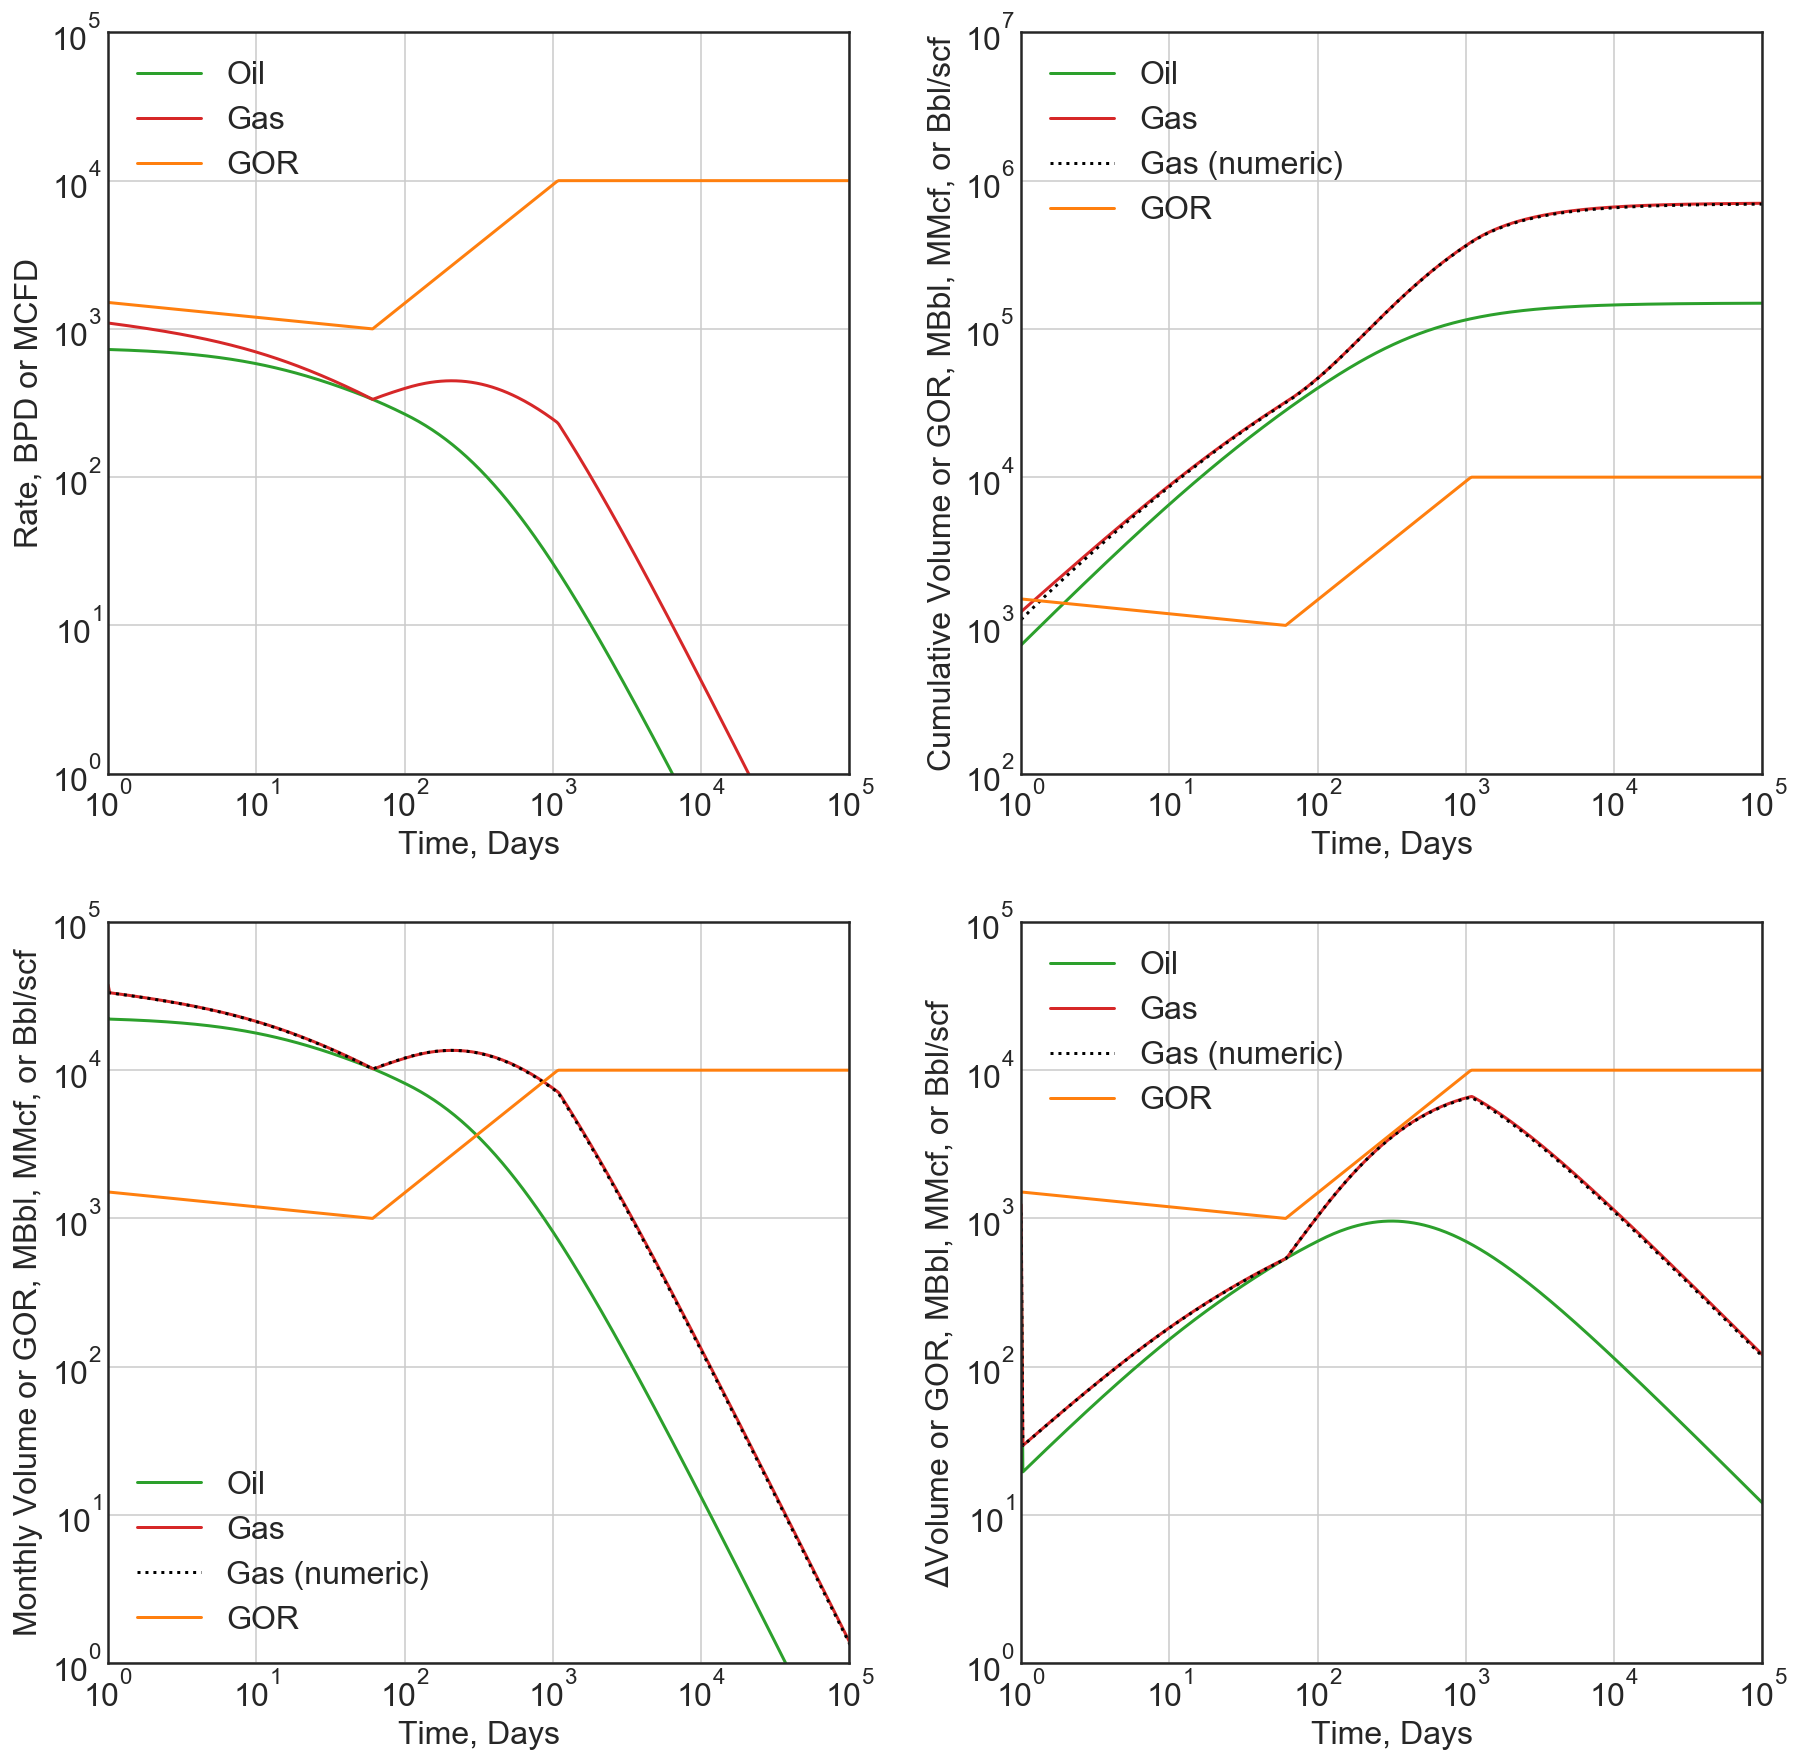

In [13]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


# Rate vs Time
q_q = thm.rate(t)
g_q = thm.secondary.rate(t)
y = thm.secondary.gor(t)

ax1.plot(t, q_q, c='C2', label='Oil')
ax1.plot(t, g_q, c='C3', label='Gas')
ax1.plot(t, y, c='C1', label='GOR')
ax1.set(xscale='log', yscale='log', xlim=(1e0, 1e5), ylim=(1e0, 1e5))
ax1.set(ylabel='Rate, BPD or MCFD', xlabel='Time, Days')


# Cumulative Volume vs Time
q_N = thm.cum(t)
g_N = thm.secondary.cum(t)
_g_N = np.cumsum(g_q * np.diff(t, prepend=0))

ax2.plot(t, q_N, c='C2', label='Oil')
ax2.plot(t, g_N, c='C3', label='Gas')
ax2.plot(t, _g_N, c='k', ls=':', label='Gas (numeric)')
ax2.plot(t, y, c='C1', label='GOR')
ax2.set(xscale='log', yscale='log', xlim=(1e0, 1e5), ylim=(1e2, 1e7))
ax2.set(ylabel='Rate, Dimensionless', xlabel='Time, Days')
ax2.set(ylabel='Cumulative Volume or GOR, MBbl, MMcf, or Bbl/scf', xlabel='Time, Days')


# Time vs Monthly Volume
q_MN = thm.monthly_vol(t, t0=0.0)
g_MN = thm.secondary.monthly_vol(t, t0=0.0)
_g_MN = np.diff(np.cumsum(g_q * np.diff(t, prepend=0)), prepend=0) \
    / np.diff(t, prepend=0) * dca.DAYS_PER_MONTH

ax3.plot(t, q_MN, c='C2', label='Oil')
ax3.plot(t, g_MN, c='C3', label='Gas')
ax3.plot(t, _g_MN, c='k', ls=':', label='Gas (numeric)')
ax3.plot(t, y, c='C1', label='GOR')
ax3.set(xscale='log', yscale='log', xlim=(1e0, 1e5), ylim=(1e0, 1e5))
ax3.set(ylabel='Monthly Volume or GOR, MBbl, MMcf, or Bbl/scf', xlabel='Time, Days')


# Time vs Interval Volume
q_IN = thm.interval_vol(t, t0=0.0)
g_IN = thm.secondary.interval_vol(t, t0=0.0)
_g_IN = np.diff(np.cumsum(g_q * np.diff(t, prepend=0)), prepend=0)

ax4.plot(t, q_IN, c='C2', label='Oil')
ax4.plot(t, g_IN, c='C3', label='Gas')
ax4.plot(t, _g_IN, c='k', ls=':', label='Gas (numeric)')
ax4.plot(t, y, c='C1', label='GOR')
ax4.set(xscale='log', yscale='log', xlim=(1e0, 1e5), ylim=(1e0, 1e5))
ax4.set(ylabel='$\Delta$Volume or GOR, MBbl, MMcf, or Bbl/scf', xlabel='Time, Days')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect(1)
    ax.grid()
    ax.legend()

plt.savefig(img_path / 'secondary_model.png')

### Diagnostic Function Plots

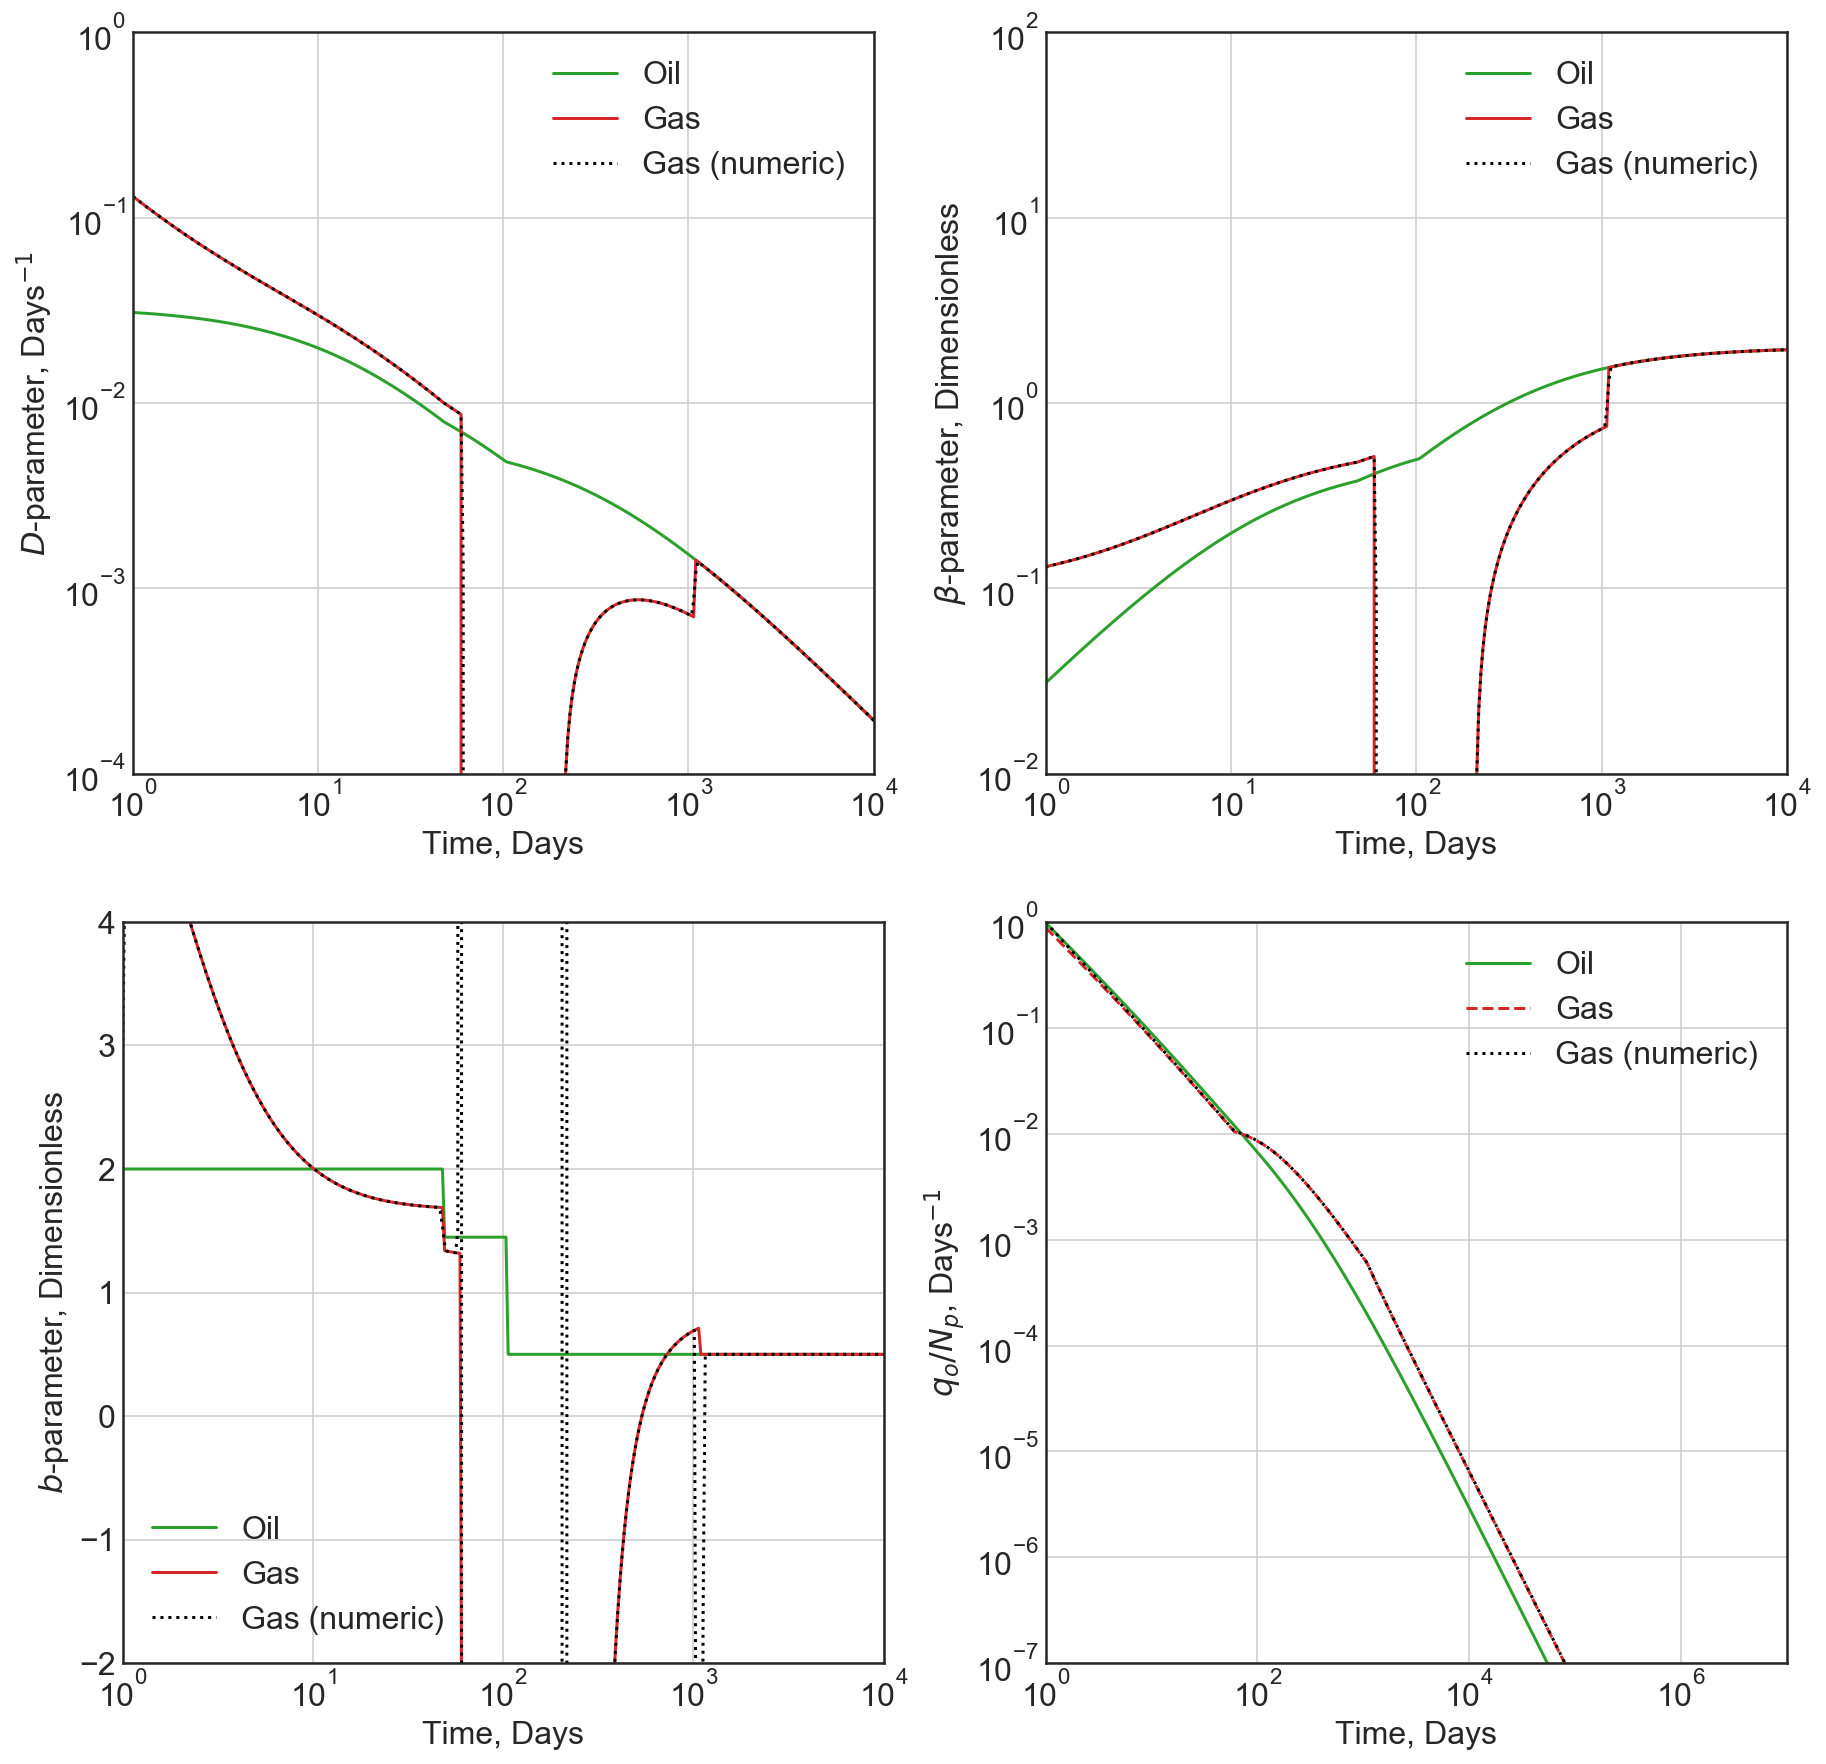

In [14]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# D-parameter vs Time
q_D = thm.D(t)
g_D = thm.secondary.D(t)
_g_D = -np.gradient(np.log(thm.secondary.rate(t)), t)

ax1.plot(t, q_D, c='C2', label='Oil')
ax1.plot(t, g_D, c='C3', label='Gas')
ax1.plot(t, _g_D, c='k', ls=':', label='Gas (numeric)')
ax1.set(xscale='log', yscale='log', xlim=(1e0, 1e4), ylim=(1e-4, 1e0))
ax1.set(ylabel='$D$-parameter, Days$^{-1}$', xlabel='Time, Days')

# beta-parameter vs Time
q_beta = thm.beta(t)
g_beta = thm.secondary.beta(t)
_g_beta = _g_D * t

ax2.plot(t, q_beta, c='C2', label='Oil')
ax2.plot(t, g_beta, c='C3', label='Gas')
ax2.plot(t, _g_beta, c='k', ls=':', label='Gas (numeric)')
ax2.set(xscale='log', yscale='log', xlim=(1e0, 1e4), ylim=(1e-2, 1e2))
ax2.set(ylabel=r'$\beta$-parameter, Dimensionless', xlabel='Time, Days')

# b-parameter vs Time
q_b = thm.b(t)
g_b = thm.secondary.b(t)
_g_b = np.gradient(1.0 / _g_D, t)

ax3.plot(t, q_b, c='C2', label='Oil')
ax3.plot(t, g_b, c='C3', label='Gas')
ax3.plot(t, _g_b, c='k', ls=':', label='Gas (numeric)')
ax3.set(xscale='log', yscale='linear', xlim=(1e0, 1e4), ylim=(-2, 4))
ax3.set(ylabel='$b$-parameter, Dimensionless', xlabel='Time, Days')

# q/N vs Time
q_Ng = thm.rate(t) / thm.cum(t)
g_Ng = thm.secondary.rate(t) / thm.secondary.cum(t)
_g_Ng = thm.secondary.rate(t) / np.cumsum(g_q * np.diff(t, prepend=0))

ax4.plot(t, q_Ng, c='C2', label='Oil')
ax4.plot(t, g_Ng, c='C3', ls='--', label='Gas')
ax4.plot(t, _g_Ng, c='k', ls=':', label='Gas (numeric)')
ax4.set(xscale='log', yscale='log', ylim=(1e-7, 1e0), xlim=(1e0, 1e7))
ax4.set(ylabel='$q_o / N_p$, Days$^{-1}$', xlabel='Time, Days')

for ax in [ax1, ax2, ax3, ax4]:
    if ax != ax3:
        ax.set_aspect(1)
    ax.grid()
    ax.legend()

plt.savefig(img_path / 'sec_diagnostic_funs.png')

### Additional Diagnostic Plots

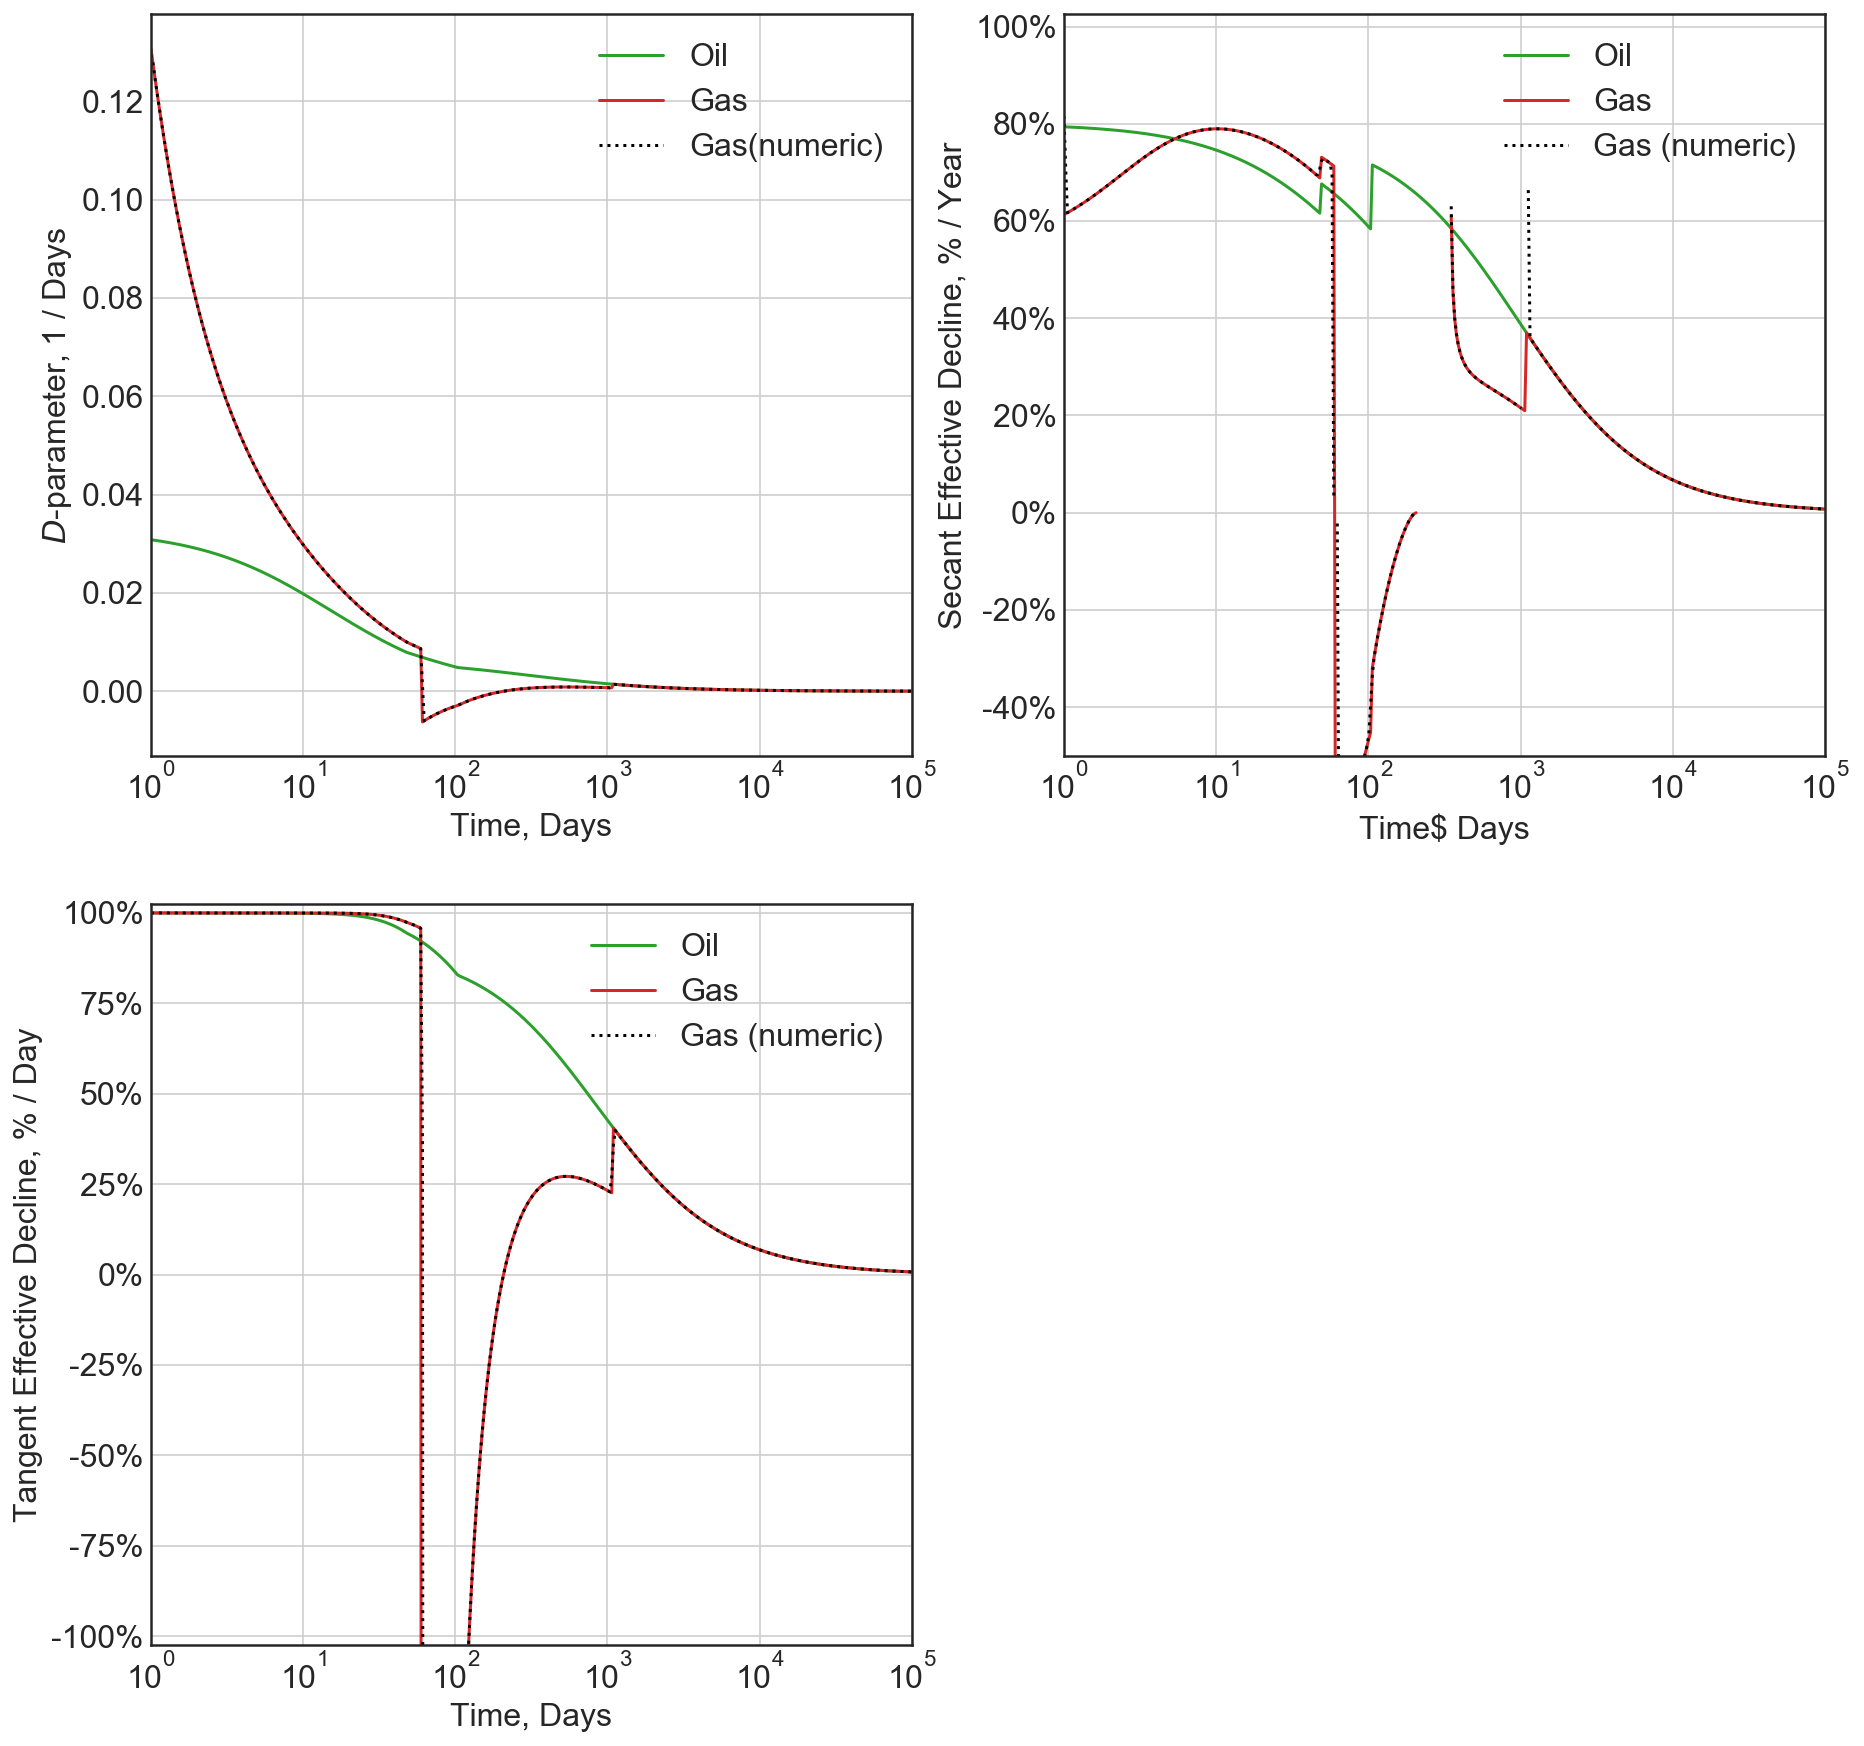

In [15]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

# D-parameter vs Time
q_D = thm.D(t)
g_D = thm.secondary.D(t)
_g_D = -np.gradient(np.log(thm.secondary.rate(t)), t)

ax1.plot(t, q_D, c='C2', label='Oil')
ax1.plot(t, g_D, c='C3', label='Gas')
ax1.plot(t, _g_D, c='k', ls=':', label='Gas(numeric)')
ax1.set(xscale='log', yscale='linear', xlim=(1e0, 1e5), ylim=(None, None))
ax1.set(ylabel='$D$-parameter, 1 / Days', xlabel='Time, Days')

# Secant Effective Decline vs Time
secant_from_nominal = dca.MultisegmentHyperbolic.secant_from_nominal
dpy = dca.DAYS_PER_YEAR

q_Dn = [secant_from_nominal(d * dpy, b) for d, b in zip(q_D, thm.b(t))]
g_Dn = [secant_from_nominal(d * dpy, b) for d, b in zip(g_D, thm.secondary.b(t))]
_g_Dn = [secant_from_nominal(d * dpy, b) for d, b in zip(_g_D, np.gradient(1 / _g_D, t))]

ax2.plot(t, q_Dn, c='C2', label='Oil')
ax2.plot(t, g_Dn, c='C3', label='Gas')
ax2.plot(t, _g_Dn, c='k', ls=':', label='Gas (numeric)')
ax2.set(xscale='log', yscale='linear', xlim=(1e0, 1e5), ylim=(-.5, 1.025))
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax2.set(ylabel='Secant Effective Decline, % / Year', xlabel='Time$ Days')

# Tangent Effective Decline vs Time
ax3.plot(t, 1 - np.exp(-q_D * dpy), c='C2', label='Oil')
ax3.plot(t, 1 - np.exp(-g_D * dpy), c='C3', label='Gas')
ax3.plot(t, 1 - np.exp(-_g_D * dpy), c='k', ls=':', label='Gas (numeric)')
ax3.set(xscale='log', yscale='linear', xlim=(1e0, 1e5), ylim=(-1.025, 1.025))
ax3.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax3.set(ylabel='Tangent Effective Decline, % / Day', xlabel='Time, Days')

for ax in [ax1, ax2, ax3]:
    ax.grid()
    ax.legend()

plt.savefig(img_path / 'sec_decline_diagnostics.png')